In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn
import torch.optim
import torch.utils.data

import time
import math

In [2]:
import importlib
import LearningCutsUtils.LearningCutsUtils
## needed if we change LearningCutsUtils and want to avoid reloading the kernel to see the effects
importlib.reload(LearningCutsUtils.LearningCutsUtils)
import LearningCutsUtils.LearningCutsUtils as LCU
from LearningCutsUtils.LearningCutsUtils import getBack, ListToGraph, OneToOneLinear, EfficiencyScanNetwork
from LearningCutsUtils.LearningCutsUtils import loss_fn
from LearningCutsUtils.LearningCutsUtils import effic_loss_fn

In [3]:
N=20000 # number of points
m=10 # dimensions

In [4]:
# array of means and widths for gaussians,
# indices are:
# - number of dimensions
# - signal (0) vs background (1)
# - mean (0) vs width (1)
np.random.seed(123)

# if we want more control over the function, for example
means_widths=[[[4,0.4],
               [-2,.10]],
              [[3,1.0],
               [-1,0.5]]]

means_widths=np.random.randn(m,2,2)               
width_scale_factor=2.
mean_scale_factor=2.

# now construct the training data.  after taking transpose, should be N rows by m columns.  
x_signal=np.array([means_widths[i][0][0]+width_scale_factor*np.fabs(means_widths[i][0][1])*np.random.randn(N) for i in range(m)]).T
y_signal=np.ones(N)
x_backgr=np.array([means_widths[i][1][0]+width_scale_factor*np.fabs(means_widths[i][1][1])*np.random.randn(N) for i in range(m)]).T
y_backgr=np.zeros(N)
x=np.concatenate((x_signal,x_backgr))
y=np.concatenate((y_signal,y_backgr))

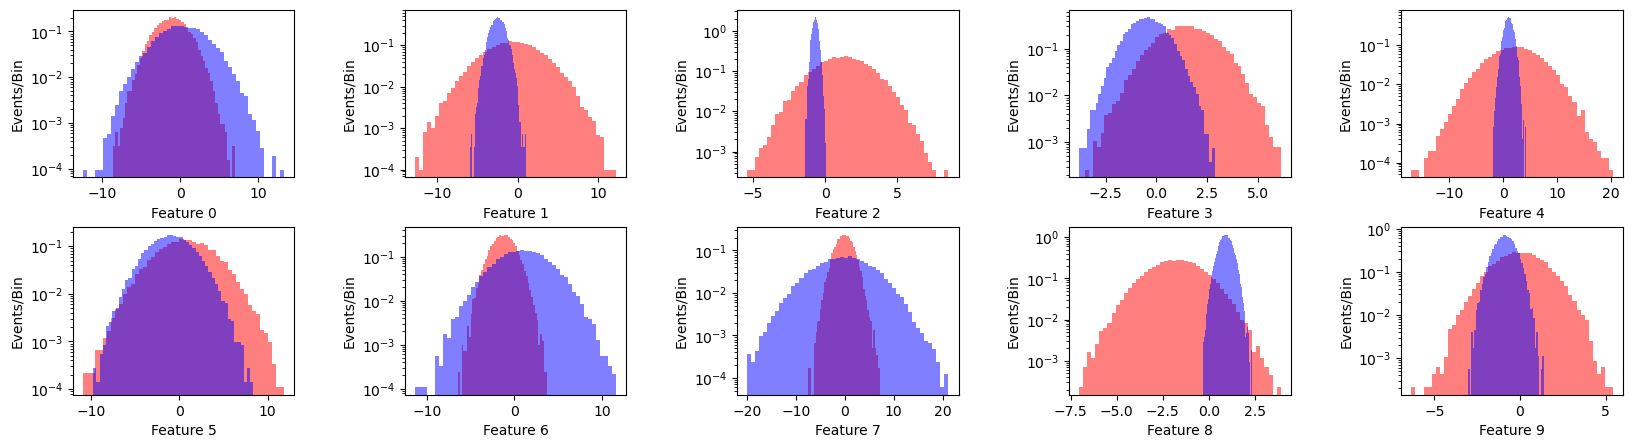

In [5]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [7]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

In [8]:
gt=1.
lt=-1.
cuts_gt_lt = [lt, gt, gt, gt, lt,
              gt, lt, lt, lt, gt]

In [9]:
targeteffics=[0.6,0.7,0.8,0.9]

# some hyperparameters
activation_input_scale_factor=8
learning_rate=0.5
batch_size=int(len(y_train)/1.) # only one batch
epochs=100
alpha=10.   # scaling factor to tune how important hitting the target signal efficiency is
beta=1.     # scaling factor to tune how important background rejection is
gamma=1e-3  # scaling factor for how aggressively to push the cuts to zero
epsilon=1e-2   # how much to penalize deviations

In [10]:
torch.manual_seed(123)

net = EfficiencyScanNetwork(m,targeteffics,cuts_gt_lt,activation_input_scale_factor) # will take m inputs, return m*n_eff outputs
torch.save(net.state_dict(), 'net_learningbiases_effictarget_untrained.pth')

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.1)